## How to select predictors for the ESD model

Here we domostrate how to use the predictor selection methods implemented in pyESD to select the set of predictor appropriate for a specific station and climate information predictand. 

We show the performace of the predictors selected by Recurssive, Sequential, and TreeBased methods and evaluate thier performace with a base model. 


In [2]:
# import all the models required
import os 
import sys 
import pandas as pd 
import numpy as np 
from collections import OrderedDict
import socket

# modules related to pyESD

from pyESD.Weatherstation import read_station_csv
from pyESD.standardizer import MonthlyStandardizer
from pyESD.ESD_utils import store_pickle, store_csv
from pyESD.splitter import KFold
from pyESD.ESD_utils import Dataset
from pyESD.Weatherstation import read_weatherstationnames

### Data repositories
To avoid the repetition of the paths to the predictors and predictand datasets, we have included them in a script that can easily be imported in all the notebooks
1. The ERA5 datasets loaded with the Dataset module implemented in the ```pyESD.ESD_utils```
2. The constructed time series of the predictors are stored in a pickle file to avoid loading them again on the next run. We set the predictordir to store the datasets
3. We use the ```read_weatherstationnames``` to generated a list of all the weather station names that would be used to create the weather station objects
4. We import all these variable as ```from read_data import * ``` which is this file: [read_data.py](./read_data.py)

All the weather stations are stored in [data](./data)

### Predictors setting 
1. list of predictors to be loaded. Note that these names are the variables names stored in the netCDF files containing the predictors datasets
2. set the date range that would be used to selected the predictors. Here it should be the same as the training and validation period


In [22]:
# potential predictor sets
predictors = ["t2m", "tp","msl", "v10", "u10", 
              "u250", "u850", "u500","u700", "u1000",
              "v250", "v850", "v500","v700", "v1000",
              "r250", "r850", "r500","r700", "r1000", 
              "z250", "z500", "z700", "z850", "z1000", 
              "t250", "t850", "t500","t700", "t1000",
              "dtd250", "dtd850", "dtd500","dtd700", 
              "dtd1000"
              ]

# training and validation period
from1958to2010 = pd.date_range(start="1958-01-01", end="2010-12-31", freq="MS")

### Predictor selection experiment function
Now we will create a function that would perform all the modeling routines so that we can easily loop through all the stations to perform the same task
1. read the station data as object that would apply all the ESD routines
2. set predictors with the list of predictors defined and the radius to construct the regional means
3. standardize the data with any of the standardizers. Here we use the MonthlyStandardizer method
4. defined the scoring metrics to be used for the validation
5. set the model to be used for the ESD training (here we will use the Ridge CV model)
6. fit the model, here we have to define the predictor selector method to be used for selecting the predictors
7. get the selected predictors 
8. use the cross_validate_predict to get the cross-validation metrics of the model training 
9. store the selected predictors 
10. stored the validation metrics

In [30]:

def run_predictor_selection_example(variable, regressor, selector_method, cachedir, stationnames,
                    station_datadir, predictors, predictordir, radius):
    """
    Run an experiment using pyESD to perform predictor selection for a given variable.

    Args:
        variable (str): The target variable to predict, here Precipitation.
        regressor (str): The regression method to use, here we use the RidgeCV regression to test all the predictor selection
        methods.
        selector_method (str): The method for selecting predictors ("Recursive", "TreeBased", "Sequential").
        cachedir (str): Directory to store cached results, here all the files would be stored in the .
        stationnames (list): List of station names. it would be loaded from the read_data file
        station_datadir (str): Directory containing station data files: this is also set in the read the data file
        predictors (list): List of predictor variables.
        predictordir (str): Directory containing predictor data files.
        radius (float): Radius for selecting predictors: also defined in the read_data file
    """
    num_of_stations = len(stationnames)

    # Loop through all stations
    for i in range(num_of_stations):
        stationname = stationnames[i]
        
        # set the exact path for the station  data
        station_dir = os.path.join(station_datadir, stationname + ".csv")
        
        # 1. create the station object using the read_station_csv and apply all the methods on the station object
        
        SO_instance = read_station_csv(filename=station_dir, varname=variable)

        # 2. Setting predictors (generate the predictors using the defined predictor names)
        SO_instance.set_predictors(variable, predictors, predictordir, radius)

        # 3. Setting standardizer
        SO_instance.set_standardizer(variable, standardizer=MonthlyStandardizer(detrending=False, scaling=False))
        
        # 4. define the scoring metrics
        scoring = ["neg_root_mean_squared_error", "r2", "neg_mean_absolute_error"]
        
        # 5. Setting model with cross-validation
        SO_instance.set_model(variable, method=regressor, scoring=scoring,
                              cv=KFold(n_splits=10))

        # 6. Fitting model with predictor selector option
        if selector_method == "Recursive":
            SO_instance.fit(variable, from1958to2010, ERA5Data, fit_predictors=True, predictor_selector=True,
                            selector_method=selector_method, selector_regressor="ARD",
                            cal_relative_importance=False)
        elif selector_method == "TreeBased":
            SO_instance.fit(variable, from1958to2010, ERA5Data, fit_predictors=True, predictor_selector=True,
                            selector_method=selector_method, selector_regressor="RandomForest")
        elif selector_method == "Sequential":
            SO_instance.fit(variable, from1958to2010, ERA5Data, fit_predictors=True, predictor_selector=True,
                            selector_method=selector_method, selector_regressor="ARD", num_predictors=10,
                            selector_direction="forward")
        else:
            raise ValueError("Define selector not recognized")

        # 7. Extracting selected predictors
        selected_predictors = SO_instance.selected_names(variable)

        # 8. Training estimate for the same model
        
        score, ypred = SO_instance.cross_validate_and_predict(variable, from1958to2010, ERA5Data)

        # 9-10. Storing results using pickle
        store_pickle(stationname, "selected_predictors_" + selector_method, selected_predictors, cachedir)
        store_pickle(stationname, "validation_score_" + selector_method, score, cachedir)


### Perform the experimet 
We now use the above function to loop through the 5 stations to perform the experiment. 

#### import all the variables defined in the read_data module (e.g., paths to data, defined radius,)

In [27]:
from read_data import radius, station_prec_datadir, stationnames_prec, ERA5Data, predictordir

### Loop through the list of methods

we now define the list of methods to test, and then loop through them to extract the predictors
for all the methods and stations 

In [25]:
selector_methods = ["Recursive", "TreeBased", "Sequential"]

In [31]:
for selector in selector_methods:
    print ("--------- running for method: ", selector, "--------")
    run_predictor_selection_example(variable="Precipitation", regressor="RidgeCV", selector_method=selector,
                                    cachedir=cachedir_prec, stationnames=stationnames_prec,
                                    station_datadir=station_prec_datadir, predictors=predictors, 
                                    predictordir=predictordir, radius=radius)

--------- running for method:  Recursive --------
Freiburg 48.0232 7.8343 236.0
Regenerating predictor data for t2m using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for tp using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for msl using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for v10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u700 using dataset ERA5 with l

Mannheim 49.5063 8.5584 98.0
Regenerating predictor data for t2m using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for tp using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for msl using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for v10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regen

Regenerating predictor data for tp using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for msl using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for v10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for 

### Checking the results
Oops! These experiments took a while to run, now its time to check if the results make sense and whether we can decide on which
predictor selection method to use for our modelling routines in the next experiments. 

All the results data are stored in the [predictor selection results folder](./predictor_selection_results)

Now we will use the functions in the ```pyESD.plot_utils``` and ```pyESD.plot``` to visualize the results


In [33]:
#path to the results
path_to_results = "C:/Users/dboateng/Desktop/Python_scripts/ESD_Package/examples/tutorials/predictor_selection_results"


#### The RidgeCV model performance using the predictor selection methods
1. We plot the R² of all the stations using the 3 methods tested
2. We plot the RMSE

In [39]:
from pyESD.plot import barplot

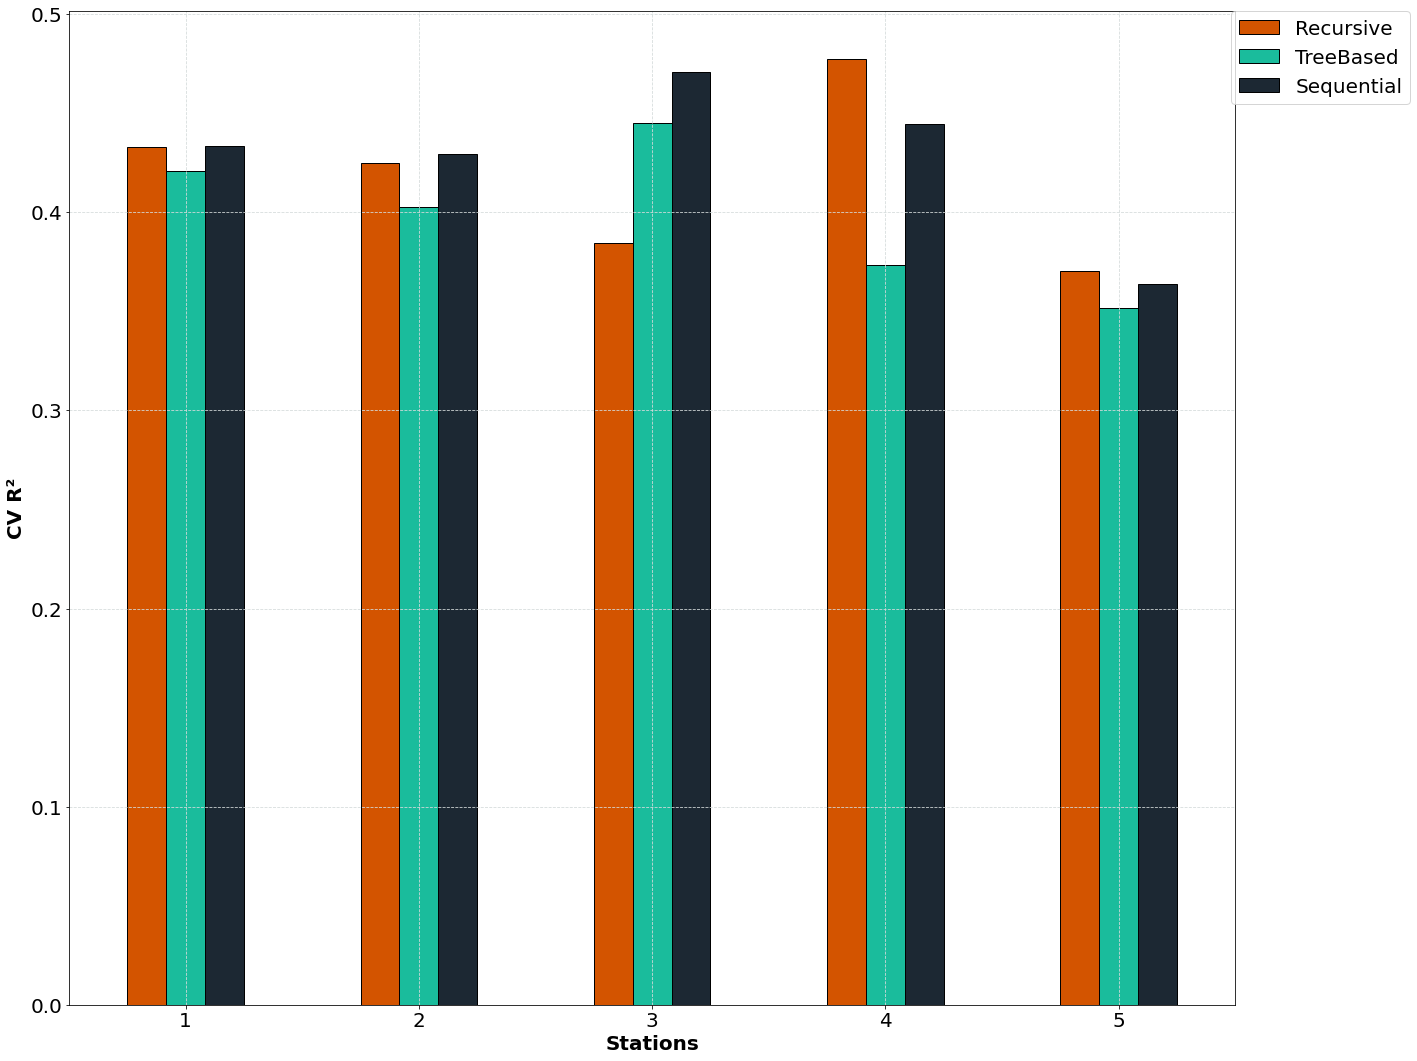

In [43]:
barplot(methods=selector_methods, stationnames=stationnames_prec , path_to_data=path_to_results, 
        xlabel="Stations", ylabel="CV R²", varname= "test_r2", varname_std ="test_r2_std",
        filename="validation_score_", legend=True,)

#### Discussion of the results 
Fantastic! Here, we can see that using a simple model (RidgeCV) with the selected predictors from the differnt methods show the differences in the individual stations. Even though the difference are not that significant, we can see that Treebased method performs worse as compared to the others for most of the station. The difference between the Recursive and Sequential is very small, therefore we can confidently select one

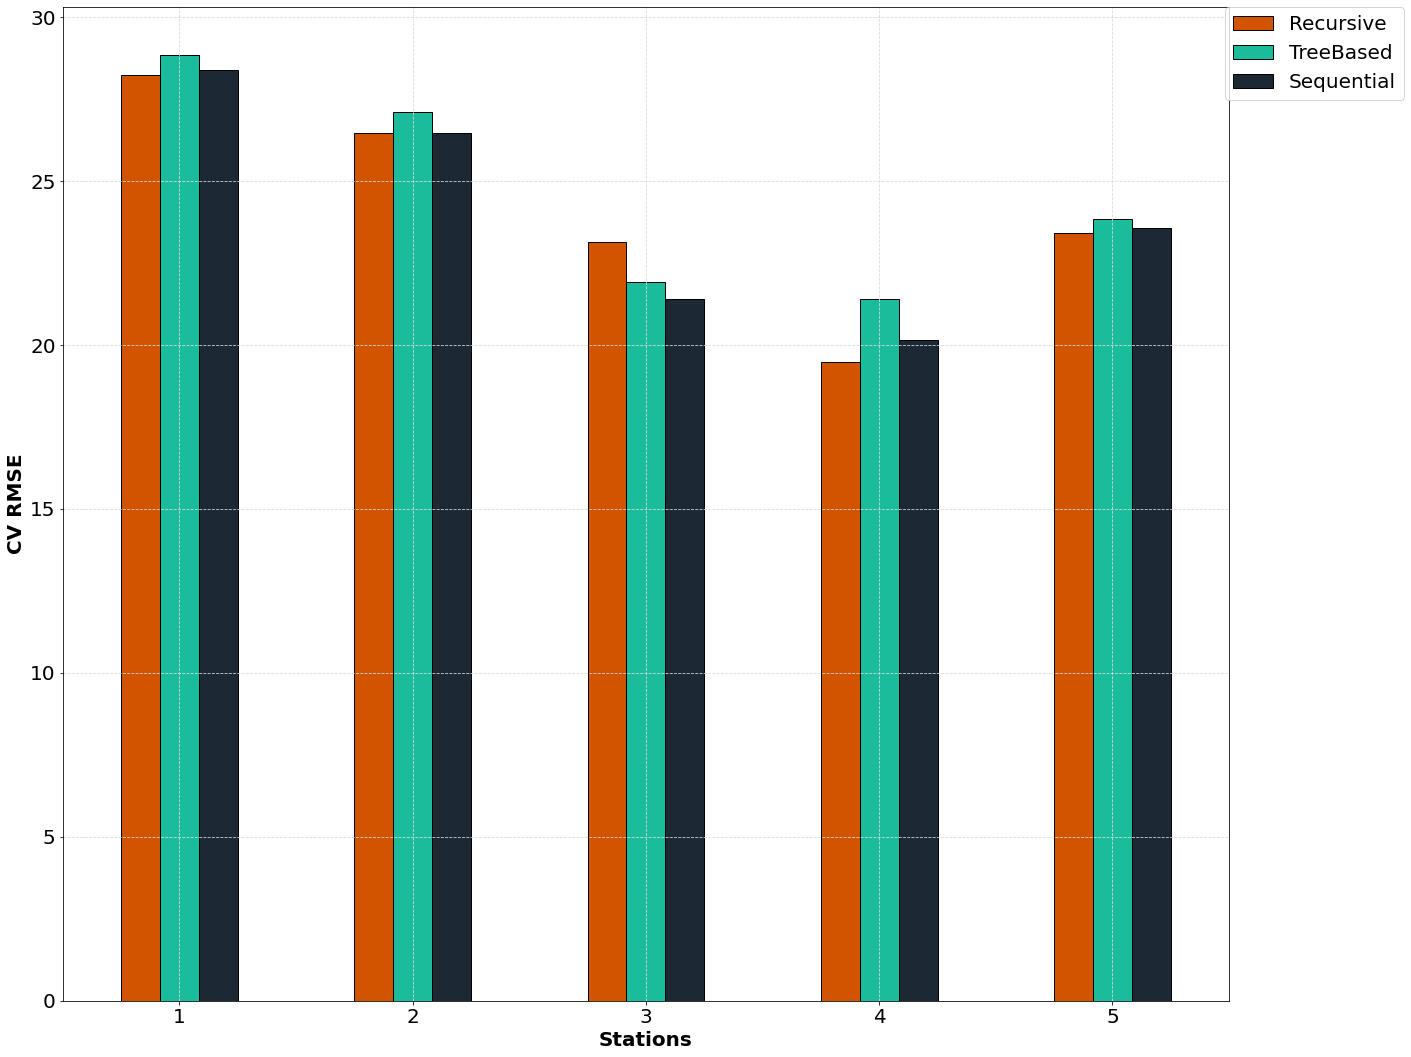

In [35]:
barplot(methods=selector_methods, stationnames=stationnames_prec , path_to_data=path_to_results, 
        xlabel="Stations", ylabel="CV RMSE", varname= "test_rmse", varname_std ="test_rmse_std",
        filename="validation_score_", )

In terms of the RMSE, the results shows consistent pattern. Therefore, we will use Recursive for the subsequent experiments


## We can also count the predictors selected 
Here we use the ```count_predictors``` function in the ```pyESD.plot_utils```

In [45]:
from pyESD.plot_utils import count_predictors

In [46]:
df = count_predictors(selector_methods, stationnames_prec, path_to_results,
                     "selected_predictors_", predictors)

In [47]:
df

,t2m,tp,msl,v10,u10,u250,u850,u500,u700,u1000,...,t250,t850,t500,t700,t1000,dtd250,dtd850,dtd500,dtd700,dtd1000
Recursive,5.0,5.0,3.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,...,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
TreeBased,NaN,5.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sequential,3.0,5.0,1.0,1.0,5.0,1.0,2.0,1.0,2.0,1.0,...,3.0,NaN,1.0,2.0,1.0,1.0,1.0,NaN,2.0,3.0


This would provide the frequency of the variables that was selected in each of the methods. Eg. First column: Temperature was selected 5x for Recursive, 0 for TreeBased and 3 for Sequential